<a href="https://colab.research.google.com/github/shaikadish/imdbProject/blob/main/twitterTopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd drive/MyDrive/twitterTopicModeling

Mounted at /content/drive
/content/drive/MyDrive/twitterTopicModeling


In [ ]:
!pip install sentence_transformers
!pip install pysentimiento
!pip install pyyaml==5.4.1
!pip install umap-learn
!pip install hdbscan
!git clone https://github.com/MaartenGr/cTFIDF.git

# Get tweets

In [7]:
import json
import os
import time
import json
from requests.api import get
from datetime import datetime
import requests
import dateutil.parser as parser
from pysentimiento.preprocessing import preprocess_tweet
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def get_recent_search_query_params(search_query,start_time,end_time, max_results = 100):

    return {'query': f"{search_query} lang:en -is:retweet",
            #'granularity': granularity,
            'start_time': start_time,
            'end_time': end_time,
            'user.fields': 'id,created_at,username,name,description,location,public_metrics,url,verified,entities',
            'tweet.fields': 'author_id,in_reply_to_user_id,created_at,conversation_id,public_metrics,lang,geo,referenced_tweets,entities',
            'expansions': 'author_id',
            'max_results': max_results}

In [9]:
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAMp9TQEAAAAAmH4NuulUuo2z0lX5kaHfD4yU6u8%3Dq0Z1rZjc9GBkc7sssQ8ni1eyYz7DDtPjnWRSUxAb8iqnubyH10'
headers = {"Authorization": "Bearer {}".format(bearer_token)}

def get_recent_search_query_params(search_query,start_time,end_time, max_results = 100):
    return {'query': f"{search_query} lang:en -is:retweet",
            'start_time': start_time,
            'end_time': end_time,
            'user.fields': 'id,created_at,username,name,description,location,public_metrics,url,verified,entities',
            'tweet.fields': 'author_id,in_reply_to_user_id,created_at,conversation_id,public_metrics,lang,geo,referenced_tweets,entities',
            'expansions': 'author_id',
            'max_results': max_results}

def recent_search_lookup(search_query,granularity='day', start_time=None, end_time=None, max_count = 50) -> dict:
    url = "https://api.twitter.com/2/tweets/search/recent"

    if start_time:
       start_time = parser.parse(start_time).isoformat()+'Z'
    if end_time:
        end_time = parser.parse(end_time).isoformat()+'Z'

    params = get_recent_search_query_params('#'+' #'.join(search_query),start_time,end_time)
    all_responses = []
    response = requests.request("GET", url, headers=headers, params = params).json()
    all_responses.extend(response['data'])
    time.sleep(2)
    id_list=[]
    
    while 'next_token' in response['meta'] and len(all_responses) < max_count:
        params['next_token'] = response['meta']['next_token']
        response = requests.request("GET", url, headers=headers, params = params).json()
        
        time.sleep(2)
          
        all_responses.extend(response['data'])

    return all_responses

In [10]:
def get_tweets(hashtags,period=7,tweet_count=100):
    """
    A function to retrieve all tweets from a historical period.
    
    :param hashtags: The list of hashtags to search for
    :param period: The number of days before today to search for tweets
    """
    today=datetime.now()
    today=today.strftime("%m/%d/%Y") # Currently taking from midnight to midnight, could do some messing around to get it to be current
    begin_period=today.split('/')
    if int(begin_period[1])<=period:
        begin_period[0]=str(int(begin_period[0])-1)
        begin_period[1]=str(31-period)
    else:
        begin_period[1]=str(int(begin_period[1])-period)
    begin_period='/'.join(begin_period)
    return recent_search_lookup(hashtags,start_time=begin_period,end_time=today,max_count=tweet_count)

In [11]:
def get_text(tags,period,tweet_count):
    tweets=get_tweets(tags,period,tweet_count)
    text=[]
    stops={'emoji','url','@usuario','usuario'}
    for tweet in tweets:
      line_list=preprocess_tweet(tweet['text'],lang="en",user_token='',url_token='').split('\n')
      if line_list[0][0]=='[' and line_list[0][-1]==']':
        line_list=line_list[1:]
      new_text=' '.join(line_list)
      new_text=' '.join([word for word in new_text.split(' ') if  not(word in stops)])
      text.append(new_text)
    return text

# Topic generation

In [12]:
from matplotlib.pyplot import get
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import pandas as pd
import umap
import hdbscan

In [13]:
def get_tweet_embedding(text):
    """
    A function to embed a set of tweets into an embedding space.
    
    :param text: The list of tweet texts
    :return: The set of embedding vectors
    """
    model=SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    embedding=[]
    for tweet in text:
        embedding.append(model.encode(tweet))
    embedding=np.array(embedding)
    return embedding

In [97]:
def get_topic_labels(vectors,min_cluster_size):
    """
    A function to uncover the topics present in a text embedding.
    
    :param vectors: A set of embedding vectors
    :return: The uncovered topics and their associated scores
    """
    fit=umap.UMAP(n_components=5,n_neighbors=15,metric='cosine')
    reduced_data=fit.fit_transform(vectors)
    cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(reduced_data)
    fit=umap.UMAP(n_components=3,n_neighbors=15,metric='cosine')
    reduced_data=fit.fit_transform(vectors)
    result=pd.DataFrame(reduced_data,columns=['x','y','z'])
    result['labels']=cluster.labels_
    clustered=result.loc[result.labels!=-1]
    ax=plt.axes(projection='3d')
    ax.scatter3D(clustered.x,clustered.y,clustered.z,c=clustered.labels)
    return cluster.labels_

In [15]:
def get_tweet_label_df(text,min_cluster_size):
  tweet_embeddings=get_tweet_embedding(text)
  labels=get_topic_labels(tweet_embeddings,min_cluster_size)
  data={'tweet':text,'label':labels}
  return pd.DataFrame(data=data)

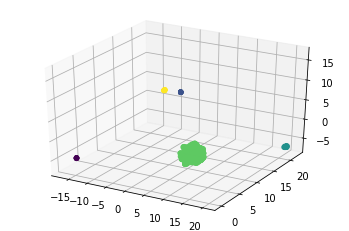

In [90]:
text=get_text(['f1'],6,1000)
tweets_with_topics=get_tweet_label_df(text,10)

# Topic Processing

In [88]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from cTFIDF.ctfidf import CTFIDFVectorizer
from nltk.corpus import stopwords
from transformers import AutoTokenizer,AutoModelForSequenceClassification

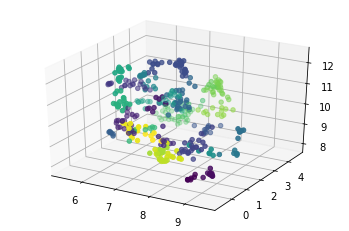

In [120]:
biggest_topic=tweets_with_topics.label.value_counts().index[0]
new_text=tweets_with_topics.tweet[tweets_with_topics.label==biggest_topic].to_list()
new_tweets_with_topics=get_tweet_label_df(new_text,5)

In [121]:
# Get data and create documents per label)

def get_top_topic_words(tweets_with_topics,n_words=10):
  docs_per_class = tweets_with_topics.groupby(['label'],as_index=False).agg({"tweet":' '.join})
  for doc in docs_per_class.iterrows():
    doc=doc[1]
    new_corpus=[]
    for word in doc.tweet.split(' '):
      if not(word in stopwords.words('english')):
        new_corpus.append(word)
    docs_per_class.loc[docs_per_class.label==doc.label,'tweet']=' '.join(new_corpus)

  # Create c-TF-IDF
  count_vectorizer = CountVectorizer().fit(docs_per_class.tweet)
  count=count_vectorizer.transform(docs_per_class.tweet)
  words=count_vectorizer.get_feature_names()

  ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(tweets_with_topics)).toarray()
  top_words = {str(label): [words[index] for index in ctfidf[label].argsort()[-n_words:]] for label in docs_per_class.label}

  return top_words

In [100]:
def get_sentiment(tweets,n_sentiments):
    """
    A function to predict the sentiment of a piece of text.
    
    :param text: The text
    :return: The sentiment score
    """
    tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis",)
    model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
    
    outputs_list=[]
    for i in range(n_sentiments):
      inputs=tokenizer(tweets[i],return_tensors='pt',truncation=True)
      outputs=model(**inputs) 
      outputs_list.append([i.item() for i in outputs.logits[0]])
    return np.array(outputs_list).mean(axis=0)

In [122]:
data={'topic':[],'top_words':[],'POS':[],'NEG':[],'NEU':[],'tweet_count':[]}
top_words=get_top_topic_words(new_tweets_with_topics)
for topic in new_tweets_with_topics.label.unique():
  if topic==-1:
    continue

  class_tweets=new_tweets_with_topics.tweet[new_tweets_with_topics['label']==topic].to_list()
  sentiment=get_sentiment(class_tweets,3)

  data['topic'].append(topic)
  data['top_words'].append(top_words[str(topic)])
  data['POS'].append(sentiment[0])
  data['NEG'].append(sentiment[1])
  data['NEU'].append(sentiment[2])
  data['tweet_count'].append(len(class_tweets))
  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [123]:
pd.DataFrame(data=data)

,topic,top_words,POS,NEG,NEU,tweet_count
0,5,"[let, seat, this, no, face, pérez, team, redbu...",-0.885266,2.081566,-1.283273,20
1,3,"[strategy, compare, messi, customers, need, da...",-3.211258,2.973073,-0.035095,21
2,10,"[garde, turbo, blame, failures, mgu, charles_,...",-3.025646,1.821940,1.009799,32
3,25,"[live, practice, sky, fp, glass, watch, friday...",0.650503,1.664492,-2.325192,12
4,17,"[help, special, auction, jay, football, finger...",-3.473416,1.320458,1.938923,14
5,6,"[away, on, light, car, dashing, driverz, flow,...",-0.398834,1.115750,-0.767830,25
6,14,"[nftcommuntiy, check, need, know, drs, tech, e...",-2.927512,1.669152,1.063387,5
7,7,"[if, fan, time, nothing, amp, wdc, think, fia,...",-3.441459,2.636449,0.544427,32
8,15,"[go, here, thinking, hand, do, wtf1, ok, again...",-0.530996,1.761351,-1.287062,7
9,29,"[wants, chances, says, unrealistic, eighth, ex...",-1.876575,1.293765,0.461540,12


In [119]:
new_tweets_with_topics[new_tweets_with_topics.label==1]

,tweet,label
1,Max Verstappen Netherlands en las últimas 13...,1
3,"Get the 2022 ferrari f1 duo, carlos sainz an...",1
4,Each teams gap to the fastest in race pace aft...,1
6,A stunning collection of the 2022 . Formula1 d...,1
9,sports sportsnews sportsbis f1 Viva Las Vegas...,1
...,...,...
736,We are proud to announce that LEMO has signed ...,1
738,Mercedes claims that their return to form in t...,1
739,Disappointment for Schumacher as quest for poi...,1
742,Your spanish gp paddocksin jhb race summary is...,1
